In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4,InceptionV3
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC, SpecificityAtSensitivity
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
def show_images(path, num_images, num_rows, num_cols):
    count = 0
    sizes = []
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    for filename in os.listdir(path):
        if count < num_images and (filename.endswith(".jpg") or filename.endswith(".png")):
            img = Image.open(os.path.join(path, filename))
            img = img.convert('RGB')

            size = img.size
            sizes.append(size)

            row = count // num_cols
            col = count % num_cols
            axs[row, col].imshow(img)
            axs[row, col].axis('off')
            count += 1
        elif count >= num_images:
            break

    avg_size = np.array(sizes).mean(axis=0)
    avg_size = np.ceil(avg_size / 32) * 32
    print("Average image size: ", avg_size)

    plt.show()

Average image size:  [416. 288.]


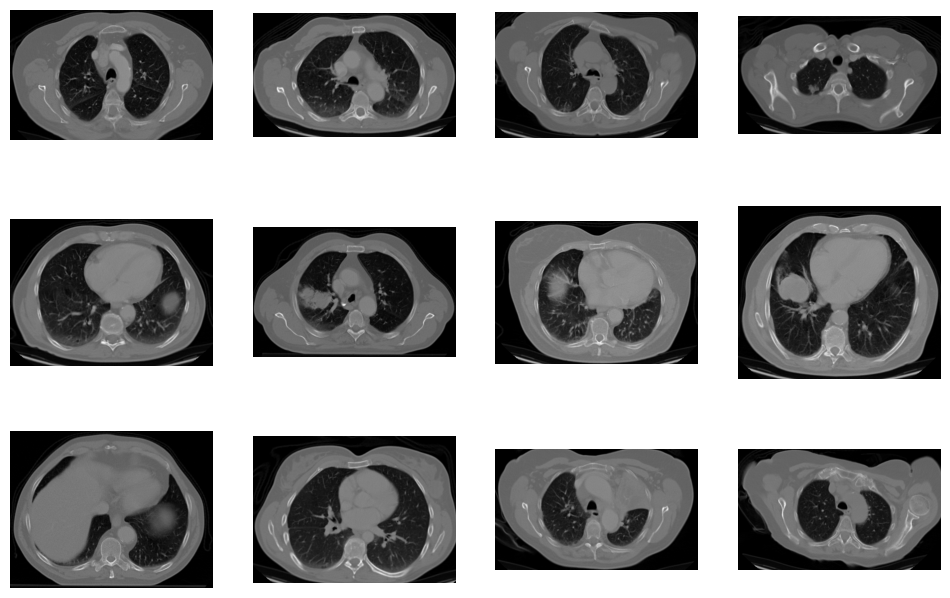

In [7]:
show_images("Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib", 12, 3, 4)

#### Base models

In [8]:
train_datagen = ImageDataGenerator(dtype='float32', rescale = 1./255, validation_split = 0.2, rotation_range=15,
                                   width_shift_range=0.1, height_shift_range=0.1, brightness_range=[0.4, 1.2],
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(dtype='float32', rescale = 1./255, validation_split = 0.2)

test_datagen  = ImageDataGenerator(dtype='float32', rescale = 1./255)

In [9]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (384,384), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (384,384), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (384,384), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [10]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3), input_shape=(384,384,3), padding='same', activation='relu', data_format='channels_last'))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 384, 384, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 384, 384, 16)      1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 192, 192, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 192, 192, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 192, 192, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 96, 96, 64)       0         
 2D)                                                    

In [11]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 8.4257 - tp: 97.0000 - fp: 223.0000 - tn: 1616.0000 - fn: 516.0000 - accuracy: 0.6986 - precision: 0.3031 - recall: 0.1582 - auc: 0.5388 - sensitivity: 0.0169
Epoch 1: val_loss improved from inf to 1.40244, saving model to model.hdf5
20/20 [==============================] - 30s 1s/step - loss: 8.4257 - tp: 97.0000 - fp: 223.0000 - tn: 1616.0000 - fn: 516.0000 - accuracy: 0.6986 - precision: 0.3031 - recall: 0.1582 - auc: 0.5388 - sensitivity: 0.0169 - val_loss: 1.4024 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 72.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6635 - val_sensitivity: 0.1296
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.3552 - tp: 12.0000 - fp: 6.0000 - tn: 1833.0000 - fn: 601.0000 - accuracy: 0.7524 - precision: 0.6667 - recall: 0.0196 - auc: 0.6433 - sensitivity: 0.3654
Epoch 2: val_loss improved from 1

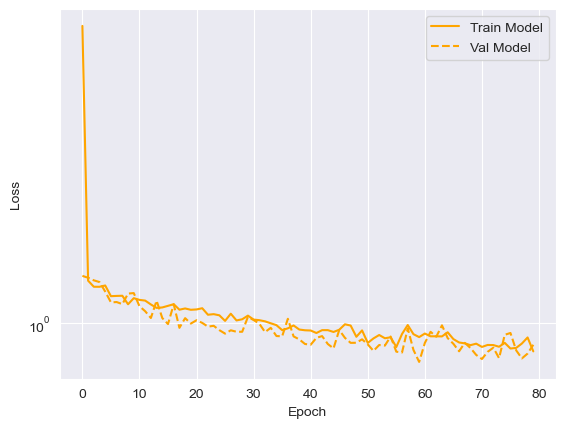

In [12]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
                 label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
                 label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [13]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 2s 96ms/step - loss: 0.8848 - tp: 96.0000 - fp: 35.0000 - tn: 910.0000 - fn: 219.0000 - accuracy: 0.7984 - precision: 0.7328 - recall: 0.3048 - auc: 0.8498 - sensitivity: 0.7312


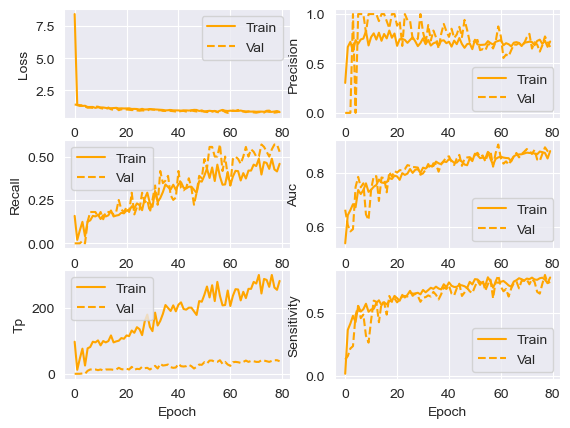

In [14]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

In [15]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3), input_shape=(384, 384,3), padding='same', activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 384, 384, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 192, 192, 8)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 192, 192, 32)      2336      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 96, 96, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 96, 96, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 294912)           

In [16]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 2.5773 - tp: 110.0000 - fp: 205.0000 - tn: 1634.0000 - fn: 503.0000 - accuracy: 0.7113 - precision: 0.3492 - recall: 0.1794 - auc: 0.5664 - sensitivity: 0.2382
Epoch 1: val_loss improved from inf to 1.26790, saving model to model.hdf5
20/20 [==============================] - 23s 1s/step - loss: 2.5773 - tp: 110.0000 - fp: 205.0000 - tn: 1634.0000 - fn: 503.0000 - accuracy: 0.7113 - precision: 0.3492 - recall: 0.1794 - auc: 0.5664 - sensitivity: 0.2382 - val_loss: 1.2679 - val_tp: 12.0000 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 60.0000 - val_accuracy: 0.7917 - val_precision: 1.0000 - val_recall: 0.1667 - val_auc: 0.5451 - val_sensitivity: 0.2731
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.2733 - tp: 59.0000 - fp: 19.0000 - tn: 1820.0000 - fn: 554.0000 - accuracy: 0.7663 - precision: 0.7564 - recall: 0.0962 - auc: 0.6693 - sensitivity: 0.4116
Epoch 2: val_loss improved from 1.26790 t

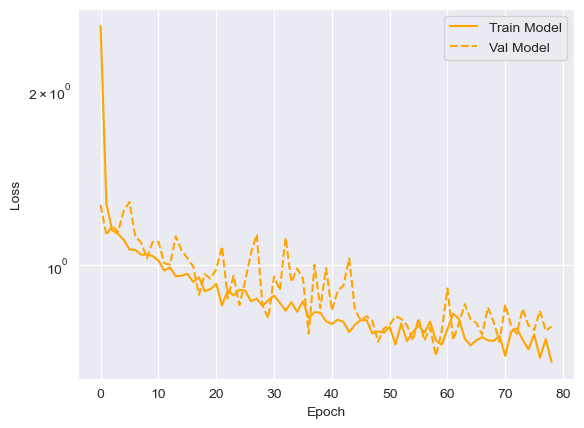

In [17]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
             label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
             label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [18]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 2s 81ms/step - loss: 1.1181 - tp: 129.0000 - fp: 72.0000 - tn: 873.0000 - fn: 186.0000 - accuracy: 0.7952 - precision: 0.6418 - recall: 0.4095 - auc: 0.7984 - sensitivity: 0.6190


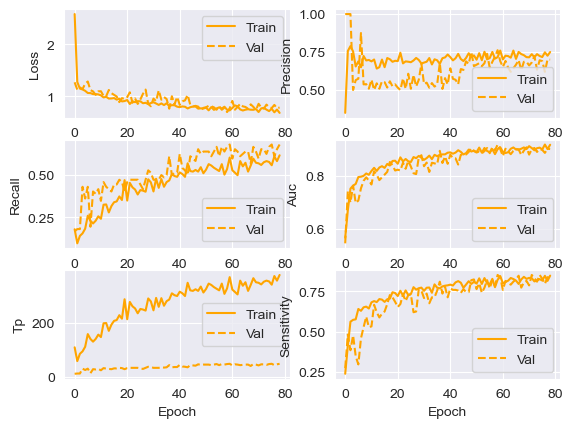

In [19]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

In [20]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3, 3), input_shape=(384,384,3), padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, kernel_regularizer = regularizers.l2(1e-3)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 384, 384, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 384, 384, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 384, 384, 8)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 192, 192, 8)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 192, 192, 32)      2336      
                                                                 
 batch_normalization_1 (Batc  (None, 192, 192, 32)    

In [21]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 73.1532 - tp: 235.0000 - fp: 369.0000 - tn: 1470.0000 - fn: 378.0000 - accuracy: 0.6954 - precision: 0.3891 - recall: 0.3834 - auc: 0.6021 - sensitivity: 0.0000e+00
Epoch 1: val_loss improved from inf to 6.73756, saving model to model.hdf5
20/20 [==============================] - 29s 1s/step - loss: 73.1532 - tp: 235.0000 - fp: 369.0000 - tn: 1470.0000 - fn: 378.0000 - accuracy: 0.6954 - precision: 0.3891 - recall: 0.3834 - auc: 0.6021 - sensitivity: 0.0000e+00 - val_loss: 6.7376 - val_tp: 22.0000 - val_fp: 50.0000 - val_tn: 166.0000 - val_fn: 50.0000 - val_accuracy: 0.6528 - val_precision: 0.3056 - val_recall: 0.3056 - val_auc: 0.5861 - val_sensitivity: 0.0000e+00
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 17.3415 - tp: 183.0000 - fp: 237.0000 - tn: 1602.0000 - fn: 430.0000 - accuracy: 0.7280 - precision: 0.4357 - recall: 0.2985 - auc: 0.6110 - sensitivity: 0.0734
Epoch 2: val_loss improved 

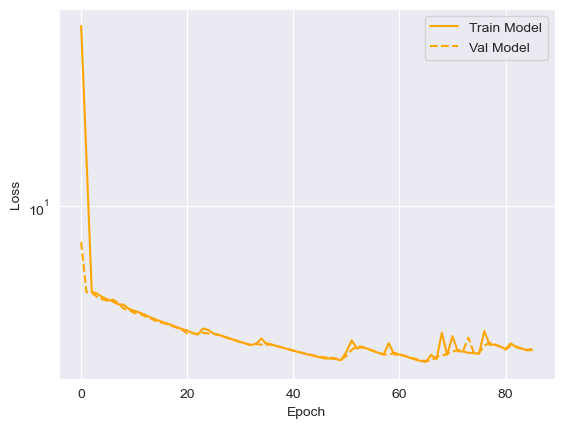

In [22]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
             label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
             label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [23]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 2s 77ms/step - loss: 2.0220 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 945.0000 - fn: 315.0000 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6286 - sensitivity: 0.2794


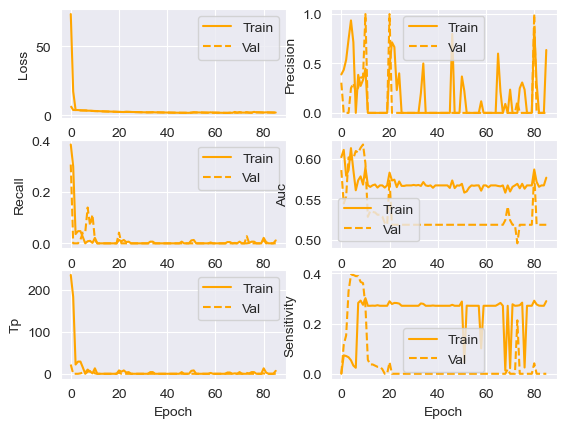

In [24]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

In [25]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3, 3), input_shape=(384,384,3), padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 384, 384, 8)       224       
                                                                 
 batch_normalization_2 (Batc  (None, 384, 384, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 384, 384, 8)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 192, 192, 8)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 192, 192, 16)      1168      
                                                                 
 batch_normalization_3 (Batc  (None, 192, 192, 16)    

In [26]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 41.0300 - tp: 194.0000 - fp: 404.0000 - tn: 1435.0000 - fn: 419.0000 - accuracy: 0.6644 - precision: 0.3244 - recall: 0.3165 - auc: 0.5686 - sensitivity: 0.1827
Epoch 1: val_loss improved from inf to 3.42165, saving model to model.hdf5
20/20 [==============================] - 21s 945ms/step - loss: 41.0300 - tp: 194.0000 - fp: 404.0000 - tn: 1435.0000 - fn: 419.0000 - accuracy: 0.6644 - precision: 0.3244 - recall: 0.3165 - auc: 0.5686 - sensitivity: 0.1827 - val_loss: 3.4217 - val_tp: 12.0000 - val_fp: 52.0000 - val_tn: 164.0000 - val_fn: 60.0000 - val_accuracy: 0.6111 - val_precision: 0.1875 - val_recall: 0.1667 - val_auc: 0.4855 - val_sensitivity: 0.0000e+00
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.7920 - tp: 48.0000 - fp: 73.0000 - tn: 1766.0000 - fn: 565.0000 - accuracy: 0.7398 - precision: 0.3967 - recall: 0.0783 - auc: 0.5499 - sensitivity: 0.1800
Epoch 2: val_loss improved from 3.4

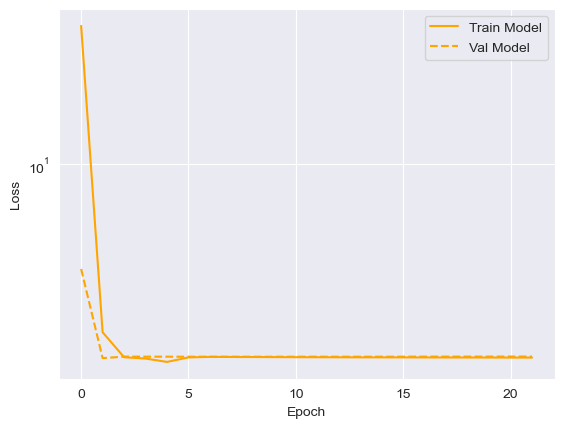

In [27]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
             label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
             label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [28]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 2s 107ms/step - loss: 1.3674 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 945.0000 - fn: 315.0000 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6286 - sensitivity: 0.2794


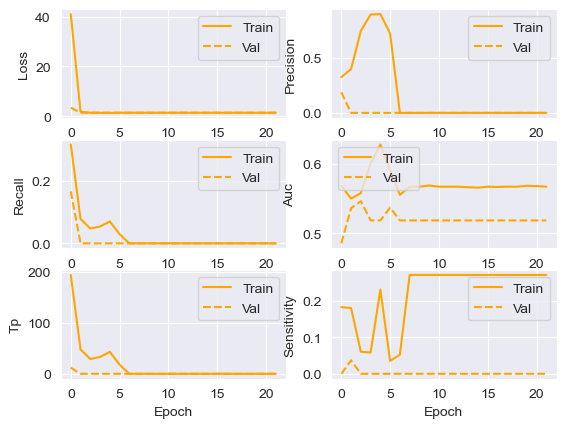

In [29]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

In [30]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3, 3), input_shape=(384,384,3), padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dense(128, kernel_regularizer = regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 384, 384, 8)       224       
                                                                 
 batch_normalization_4 (Batc  (None, 384, 384, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 384, 384, 8)       0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 192, 192, 8)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 192, 192, 32)      2336      
                                                                 
 batch_normalization_5 (Batc  (None, 192, 192, 32)    

In [31]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 48.2939 - tp: 206.0000 - fp: 397.0000 - tn: 1442.0000 - fn: 407.0000 - accuracy: 0.6721 - precision: 0.3416 - recall: 0.3361 - auc: 0.5816 - sensitivity: 0.2980
Epoch 1: val_loss improved from inf to 1.28970, saving model to model.hdf5
20/20 [==============================] - 20s 905ms/step - loss: 48.2939 - tp: 206.0000 - fp: 397.0000 - tn: 1442.0000 - fn: 407.0000 - accuracy: 0.6721 - precision: 0.3416 - recall: 0.3361 - auc: 0.5816 - sensitivity: 0.2980 - val_loss: 1.2897 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 70.0000 - val_accuracy: 0.7569 - val_precision: 1.0000 - val_recall: 0.0278 - val_auc: 0.6337 - val_sensitivity: 0.4306
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.9652 - tp: 39.0000 - fp: 41.0000 - tn: 1798.0000 - fn: 574.0000 - accuracy: 0.7492 - precision: 0.4875 - recall: 0.0636 - auc: 0.5597 - sensitivity: 0.1359
Epoch 2: val_loss did not improve fro

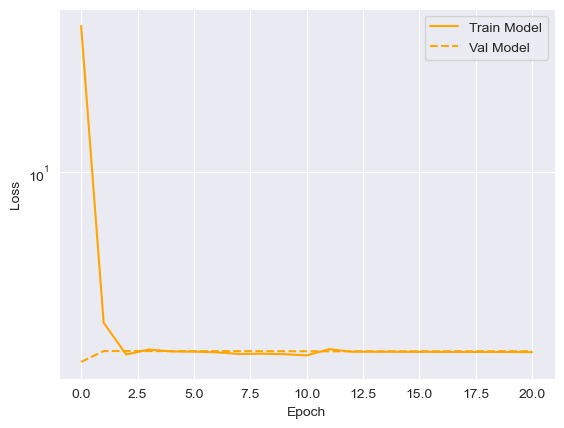

In [32]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
             label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
             label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [33]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 2s 88ms/step - loss: 1.4177 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 945.0000 - fn: 315.0000 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6286 - sensitivity: 0.2794


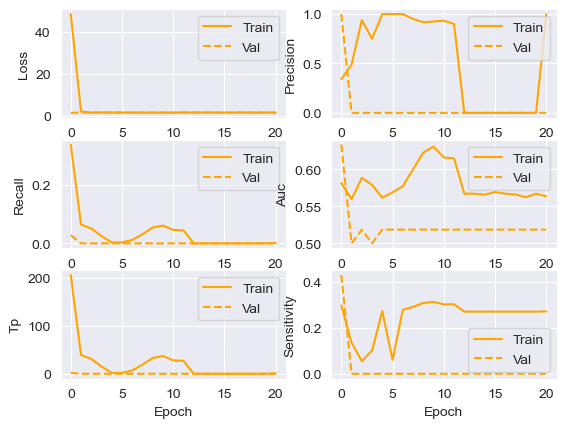

In [34]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

In [35]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), input_shape=(384, 384,3), padding='same', activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 384, 384, 16)      1216      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 192, 192, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 192, 192, 64)      9280      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 96, 96, 64)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 96, 96, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 589824)           

In [36]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 10.7772 - tp: 84.0000 - fp: 203.0000 - tn: 1636.0000 - fn: 529.0000 - accuracy: 0.7015 - precision: 0.2927 - recall: 0.1370 - auc: 0.5416 - sensitivity: 0.2403
Epoch 1: val_loss improved from inf to 1.37308, saving model to model.hdf5
20/20 [==============================] - 32s 2s/step - loss: 10.7772 - tp: 84.0000 - fp: 203.0000 - tn: 1636.0000 - fn: 529.0000 - accuracy: 0.7015 - precision: 0.2927 - recall: 0.1370 - auc: 0.5416 - sensitivity: 0.2403 - val_loss: 1.3731 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 72.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5529 - val_sensitivity: 0.2546
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.3246 - tp: 50.0000 - fp: 16.0000 - tn: 1823.0000 - fn: 563.0000 - accuracy: 0.7639 - precision: 0.7576 - recall: 0.0816 - auc: 0.6453 - sensitivity: 0.3861
Epoch 2: val_loss improved fro

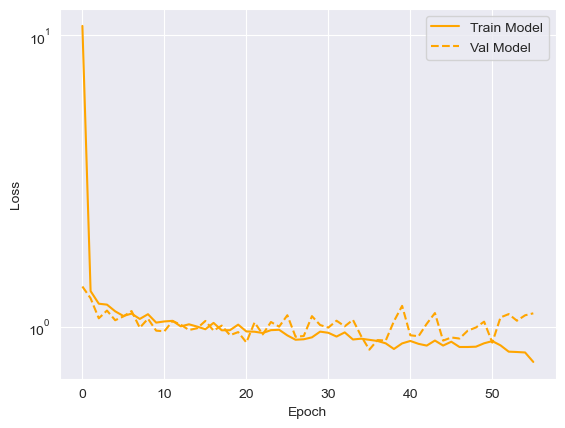

In [37]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
             label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
             label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [38]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 3s 148ms/step - loss: 0.9447 - tp: 164.0000 - fp: 110.0000 - tn: 835.0000 - fn: 151.0000 - accuracy: 0.7929 - precision: 0.5985 - recall: 0.5206 - auc: 0.8462 - sensitivity: 0.7238


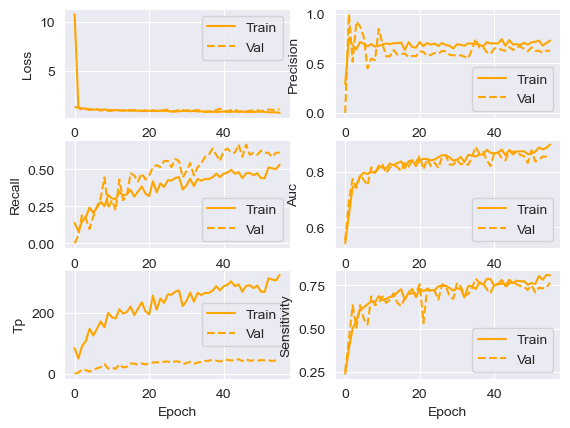

In [39]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

## Transfer Learning

### InceptionV3

In [40]:
from keras.applications.inception_v3 import preprocess_input

def my_preprocess_input(x):
    x = preprocess_input(x)
    return x

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=my_preprocess_input)

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=my_preprocess_input)

test_datagen  = ImageDataGenerator(dtype='float32', preprocessing_function=my_preprocess_input)

In [41]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (384,384), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (384,384), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (384,384), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [42]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(384,384, 3))
for layer in inception_model.layers:
    layer.trainable = False

In [43]:
model = Sequential()
model.add(inception_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 10, 10, 2048)      21802784  
                                                                 
 dropout_13 (Dropout)        (None, 10, 10, 2048)      0         
                                                                 
 flatten_6 (Flatten)         (None, 204800)            0         
                                                                 
 dense_13 (Dense)            (None, 256)               52429056  
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 74,232,868
Trainable params: 52,430,084


In [44]:
checkpoint = ModelCheckpoint('inception_model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 25.3113 - tp: 275.0000 - fp: 327.0000 - tn: 1512.0000 - fn: 338.0000 - accuracy: 0.7288 - precision: 0.4568 - recall: 0.4486 - auc: 0.6563 - sensitivity: 0.2289
Epoch 1: val_loss improved from inf to 2.24517, saving model to inception_model.hdf5
20/20 [==============================] - 17s 600ms/step - loss: 25.3113 - tp: 275.0000 - fp: 327.0000 - tn: 1512.0000 - fn: 338.0000 - accuracy: 0.7288 - precision: 0.4568 - recall: 0.4486 - auc: 0.6563 - sensitivity: 0.2289 - val_loss: 2.2452 - val_tp: 49.0000 - val_fp: 23.0000 - val_tn: 193.0000 - val_fn: 23.0000 - val_accuracy: 0.8403 - val_precision: 0.6806 - val_recall: 0.6806 - val_auc: 0.8070 - val_sensitivity: 0.0741
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.4073 - tp: 382.0000 - fp: 188.0000 - tn: 1651.0000 - fn: 231.0000 - accuracy: 0.8291 - precision: 0.6702 - recall: 0.6232 - auc: 0.8700 - sensitivity: 0.7858
Epoch 2: val_loss improved 

In [45]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 3s 138ms/step - loss: 0.5710 - tp: 261.0000 - fp: 52.0000 - tn: 893.0000 - fn: 54.0000 - accuracy: 0.9159 - precision: 0.8339 - recall: 0.8286 - auc: 0.9606 - sensitivity: 0.9630


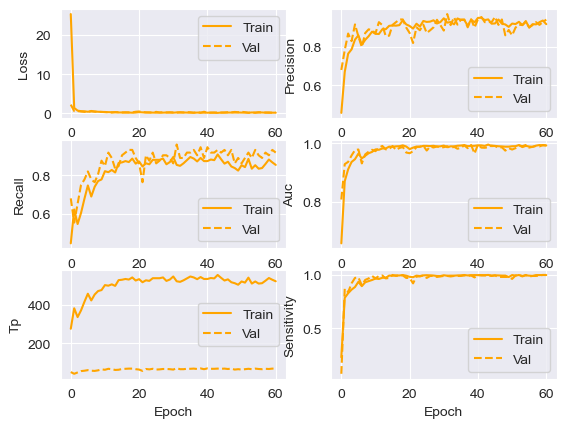

In [46]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

### ResNet50

In [47]:
train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)

test_datagen  = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)

In [48]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (384,384), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (384,384), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (384,384), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [49]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384,384, 3))
for layer in resnet_model.layers:
    layer.trainable = False

In [50]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), input_shape=(384, 384,3), padding='same', activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 384, 384, 16)      1216      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 192, 192, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_108 (Conv2D)         (None, 192, 192, 64)      9280      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 96, 96, 64)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 96, 96, 64)        0         
                                                                 
 flatten_7 (Flatten)         (None, 589824)           

In [51]:
checkpoint = ModelCheckpoint('resnet_model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1830.8367 - tp: 240.0000 - fp: 373.0000 - tn: 1466.0000 - fn: 373.0000 - accuracy: 0.6958 - precision: 0.3915 - recall: 0.3915 - auc: 0.5964 - sensitivity: 0.0000e+00
Epoch 1: val_loss improved from inf to 21.31413, saving model to resnet_model.hdf5
20/20 [==============================] - 18s 860ms/step - loss: 1830.8367 - tp: 240.0000 - fp: 373.0000 - tn: 1466.0000 - fn: 373.0000 - accuracy: 0.6958 - precision: 0.3915 - recall: 0.3915 - auc: 0.5964 - sensitivity: 0.0000e+00 - val_loss: 21.3141 - val_tp: 31.0000 - val_fp: 41.0000 - val_tn: 175.0000 - val_fn: 41.0000 - val_accuracy: 0.7153 - val_precision: 0.4306 - val_recall: 0.4306 - val_auc: 0.6304 - val_sensitivity: 0.4259
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 11.4809 - tp: 380.0000 - fp: 214.0000 - tn: 1625.0000 - fn: 233.0000 - accuracy: 0.8177 - precision: 0.6397 - recall: 0.6199 - auc: 0.7880 - sensitivity: 0.2730
Epoch 2: val_lo

In [52]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 2s 92ms/step - loss: 1.6809 - tp: 168.0000 - fp: 133.0000 - tn: 812.0000 - fn: 147.0000 - accuracy: 0.7778 - precision: 0.5581 - recall: 0.5333 - auc: 0.8196 - sensitivity: 0.6921


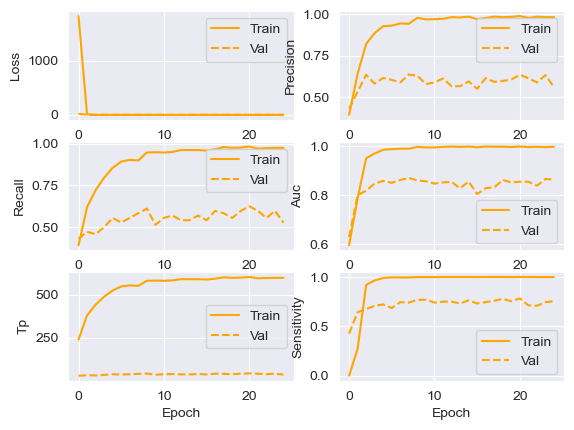

In [53]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

### VGG19

In [61]:
train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=vgg19.preprocess_input)

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=vgg19.preprocess_input)

test_datagen  = ImageDataGenerator(dtype='float32', preprocessing_function=vgg19.preprocess_input)

In [62]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (384,384), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (384,384), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (384,384), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [63]:
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(384,384, 3))
for layer in vgg19_model.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 2s 0us/step


In [64]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), input_shape=(384, 384,3), padding='same', activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_205 (Conv2D)         (None, 384, 384, 16)      1216      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 192, 192, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_206 (Conv2D)         (None, 192, 192, 64)      9280      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 96, 96, 64)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 96, 96, 64)        0         
                                                                 
 flatten_9 (Flatten)         (None, 589824)           

In [65]:
checkpoint = ModelCheckpoint('vgg19_model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1731.1542 - tp: 232.0000 - fp: 381.0000 - tn: 1458.0000 - fn: 381.0000 - accuracy: 0.6892 - precision: 0.3785 - recall: 0.3785 - auc: 0.5845 - sensitivity: 0.0000e+00
Epoch 1: val_loss improved from inf to 10.11411, saving model to vgg19_model.hdf5
20/20 [==============================] - 25s 1s/step - loss: 1731.1542 - tp: 232.0000 - fp: 381.0000 - tn: 1458.0000 - fn: 381.0000 - accuracy: 0.6892 - precision: 0.3785 - recall: 0.3785 - auc: 0.5845 - sensitivity: 0.0000e+00 - val_loss: 10.1141 - val_tp: 33.0000 - val_fp: 39.0000 - val_tn: 177.0000 - val_fn: 39.0000 - val_accuracy: 0.7292 - val_precision: 0.4583 - val_recall: 0.4583 - val_auc: 0.6590 - val_sensitivity: 0.2130
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 9.4074 - tp: 338.0000 - fp: 226.0000 - tn: 1613.0000 - fn: 275.0000 - accuracy: 0.7957 - precision: 0.5993 - recall: 0.5514 - auc: 0.7594 - sensitivity: 0.2344
Epoch 2: val_loss im

In [66]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 2s 88ms/step - loss: 2.9408 - tp: 135.0000 - fp: 173.0000 - tn: 772.0000 - fn: 180.0000 - accuracy: 0.7198 - precision: 0.4383 - recall: 0.4286 - auc: 0.6653 - sensitivity: 0.0857


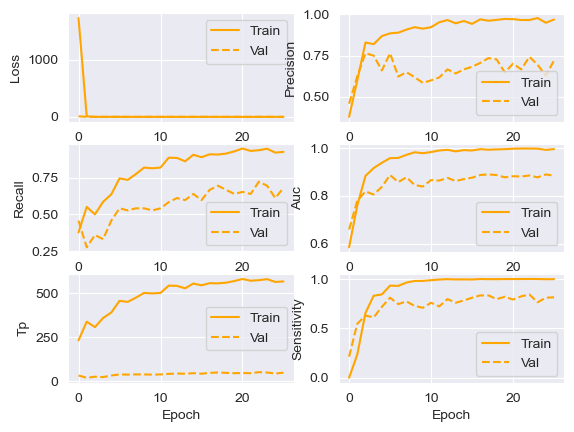

In [67]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()